# Predictions on growth of confirmed Novel Coronavirus (2019-nCoV) cases in countries 
                      By Bohan updated on July 19, 2020  
## Goal: Make an educated guess on when the spread of the novel coronavirus will stabilize (i.e. when the things will get better) in different countries

## Method: 
1. Use the data from China as an example to create logistic models for different countries 
2. Use R^2 to evaluate goodness of fit
3. Use inflection point to predict the turning point (i.e. when the number of newly confirmed cases per day will start to decrease)
4. Use 99.9% of the top horizontal asymptote value to predict when the situation wil stablize (i.e. the number of newly confirmed cases is closed to zero)

## Data: 
Publically available source from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE  
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv


## Disclaimer: 
### 1. The model assumes that everything stays constant, so the conclusions will be affected both positively and negatively by dramatic changes such as new travel restictions, shortage of health care supplies, ect
### 2. Only confirmed cases were included, so the result depends number of tests done and it does not necessarily reflect the actual infected population in each countries
### 3. I intend to update every week and conclusion may be different in each update (due to new models being generated from latest data)


## Summary:  
### 0. Update on the parameter boundary  for model, End phase and Growth phase analysis
### 1. The logistic model was applied to 130 countries
### 2. Mean turning point for these countries is on 2020-06-01
(This is an understimate because only countries close to turning points can be modeled)
### 3. Mean CurveTop for these countries is on 2020-09-30
(This is also an understimate. If you check the graphs in the bottom, you will find that the numbers in some countires did not decrease as models predict )
### 4. The numbers in various countries continue to grow steadily while some countires in Europe and Africa continue to grow in numbers.

  

In [1]:
import numpy as np;  # useful for many scientific computing in Python
import pandas as pd; # primary data structure library
import scipy as sp; # for statistical tests
import matplotlib.pyplot as plt; # for plotting
import seaborn as sns; # for heatmaps
import folium; # for world map

# add custom converters for timestamps when plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# data from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'); # import file
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,33908,34194,34366,34451,34455,34740,34994,35070,35229,35301
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3188,3278,3371,3454,3571,3667,3752,3851,3906,4008
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,17808,18242,18712,19195,19689,20216,20770,21355,21948,22549
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,855,855,855,855,858,861,862,877,880,880
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,396,458,462,506,525,541,576,607,638,687


## Create China data frame as an example
The location data and Province/State data will be ignore 

In [3]:
China = df[df['Country/Region'] == 'China'];
China.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20
49,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,991,991,991,991,991,991,991,991,991,991
50,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,...,929,929,929,929,929,929,929,929,929,929
51,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,582,582,582,582,582,583,583,583,583,583
52,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,...,363,363,363,363,363,363,363,363,363,363
53,Gansu,China,35.7518,104.2861,0,2,2,4,7,14,...,167,167,167,167,167,167,167,167,167,167


In [4]:
# calculate sums for the entire country
China_sum = China.iloc[:,4:].sum(axis=0);

## Create logistic model as
## f(x) = a / (1 + e^(-c * (x - d)) ) + b
    where x is time, 
    f(x) is Percentage confirmed cases over entire population,
    a,b,c,d are fitting parameters
    c > 0 (update on April 21, because if c<0, the top horizontal asymptote is b)

### The inflection point is at x =  -ln( abs(1 - 2a/(a-b) )) / c +d
### The top horizontal asymptote is f(x) = a + b

In [5]:
# create logistic function
def func(x, a,b,c,d): 
    return a / (1. + np.exp(-1.*c * (x - d))) + b

In [6]:
 # import curve_fit function and fit the curve
from scipy.optimize import curve_fit;
# repeate fitting three time using consecutive parameters
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=[China_sum.iloc[-1], 0,  1,  0],
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt,
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt,
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
y_fit = func(np.arange(len(China_sum)), popt[0],popt[1],popt[2],popt[3]);

In [7]:
# create a function to plot data
def p_model(s, y_fit, name, fst):
    # s: pandas series containing number of confirmed cases
    # y_fit: 1-d array containing model data 
    # name: name of country (str)
    # fst: first day of the data set (str)
    
    plt.figure(figsize=(20,15));
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(s)), unit='day'), s.to_numpy(),'b', label=name);
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(y_fit)), unit='day'), y_fit,'r--', label='Simulated');
    plt.legend(fontsize=20);
    plt.ylabel('Number of confirmed cases', fontsize=20);
    plt.title('Cumulative number of confirmed cases', fontsize=20);
    plt.xlabel('Date', fontsize=20);
    plt.show();

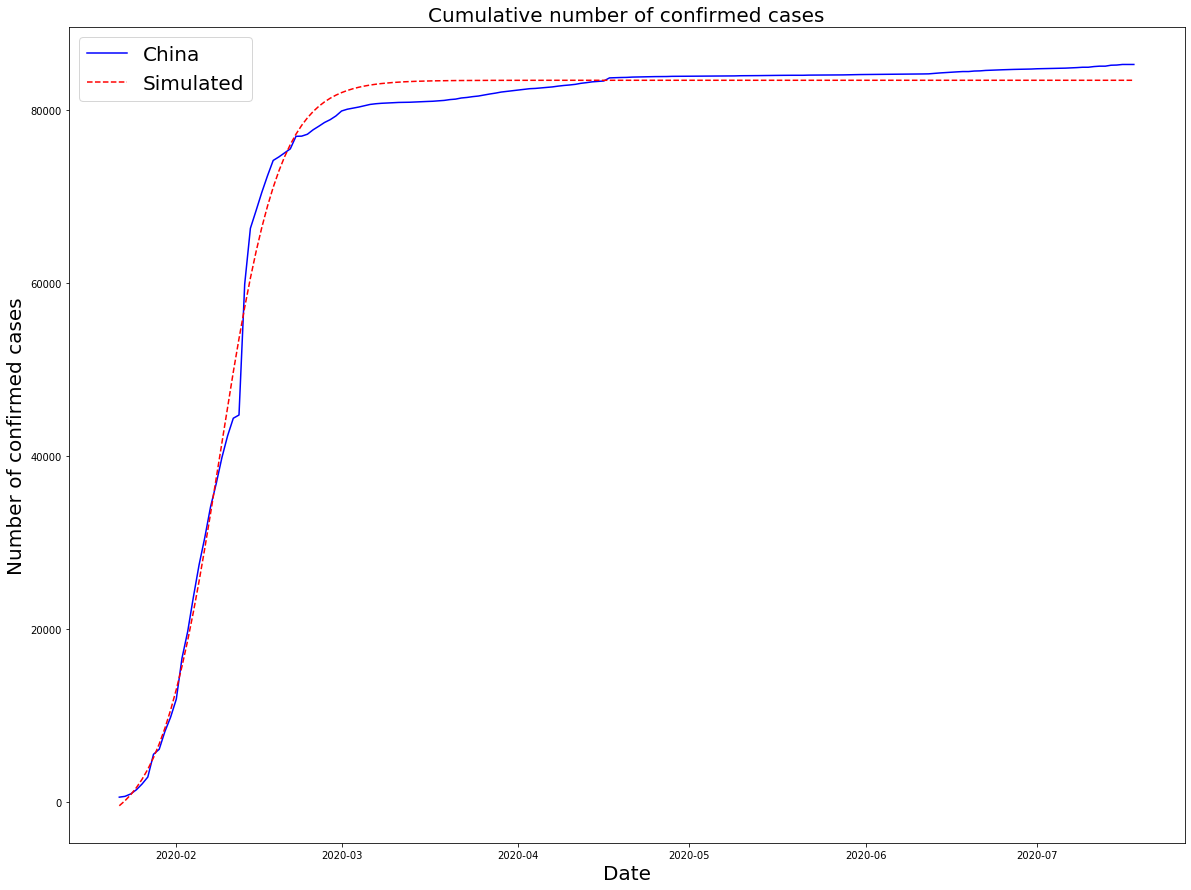

In [8]:
# plot for China
p_model(China_sum, y_fit, 'China', China_sum.index[0])

In [9]:
# define the function to caculate R^2 using residual sum of squares
def r_square(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [10]:
# The closer the R^2 is to 1, the better the fitting
print('R^2 = ', r_square(China_sum.to_numpy(), y_fit))

R^2 =  0.9941569904026318


In [11]:
# find % when the confirmed population stablized on March 18
# the inflection point is at fp = a/2
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(fb-b)))/c + d = -ln(abs(1-2a/(a-b)))/c + d
# caculate this date:
iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
print('The day reaches the turning point is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(iday, unit='day'));

The day reaches the turning point is on:  2020-02-09 00:54:57.209500800


In [12]:
# top horizontal horizontal asymptotes is a + b (popt[0] + popt[1])
# time to reach 99.9% of asymptote is at y_hor = 0.999*(a + b)
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(y_hor-b)))/c + d
# caculate this date:
dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
print('The day reaches the top of the curve is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(dday, unit='day'));
print('The total number of confirmed cases is ', popt[0]+popt[1]);

The day reaches the top of the curve is on:  2020-03-15 21:35:29.546160
The total number of confirmed cases is  83484.62729159227


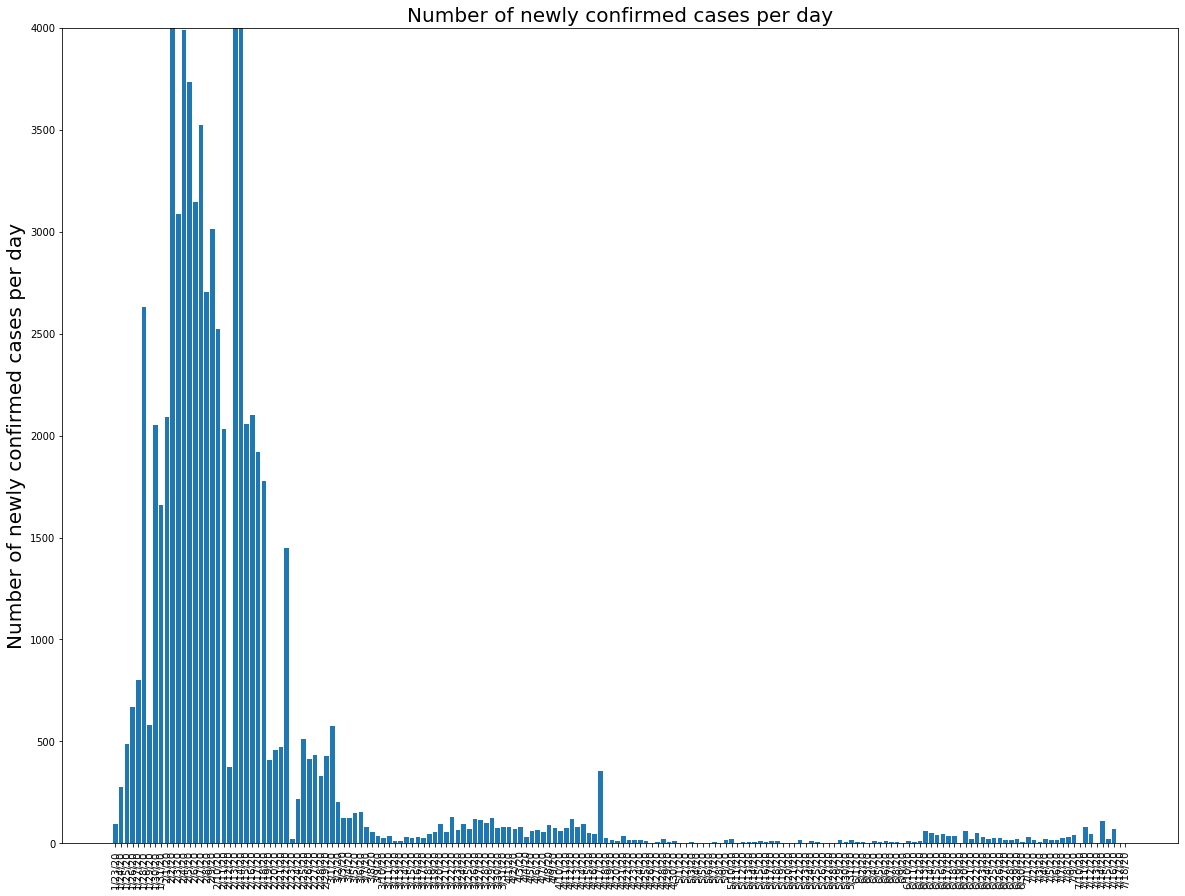

In [13]:
# plot number of newly confirmed cases
plt.figure(figsize=(20,15));
plt.bar(China_sum.index[1:], China_sum.to_numpy()[1:]-China_sum.to_numpy()[:-1]);
plt.xticks(rotation='vertical');
plt.ylim((0,4000));
plt.ylabel('Number of newly confirmed cases per day', fontsize=20);
plt.title('Number of newly confirmed cases per day', fontsize=20);

## Summary:
1. As shown in the bar graph, the number of newly confirmed cases did decrease after 2/7/2020 as perdicted by the model but it increased again on 2/13/2020.
2. After 3/8/2020, the number of newly confirmed cases stablized which closely matches the modelperdiction: 3/11/2020.  
3. Therefore, the model is suitable for making guesses.

# Predictions on Other countries

In [14]:
# fitting parameters for China
popt_china = popt;
# for storing data
POPT = [];
PCOV = [];
R2 = [];
Iday = [];
Dday = [];
NAME = [];
TotalC = [];
EndP = [];
GP = [];

# I will ignore number of confirmed cases below 400
# because good model cannot be generated from small sample size
countries = df['Country/Region'].unique()
for ct in np.arange(len(countries)):
    
    # caculate sums per country
    df1 = df[df['Country/Region'] == countries[ct]].iloc[:, 4:].sum(axis=0);
    
    # I will ignore number of confirmed cases below 400
    # because good model cannot be generated from small sample size
    if df1[-1] < 400:
        continue
    
    # try to fit the curve
    try:
        # repeate fitting three time starting with parameters for China
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), 
                               p0= [df1.iloc[-1], popt_china[1],popt_china[2],popt_china[3]], 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
    except RuntimeError:
        try: 
            # repeate fitting three time starting with zeros
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
        except RuntimeError:
            continue
    
    # calculate model curve
    y_fit = func(np.arange(len(df1)), popt[0],popt[1],popt[2],popt[3]);
    
    # calculate R^2
    # The closer the R^2 is to 1, the better the fitting
    r2 = r_square(df1.to_numpy(), y_fit);
    
    # ignore if R^2 value is less than 0.98 or above one (indeicating poor fits)
    if r2 < 0.98 or r2 > 1:
        continue
    
    # print country name
    print(countries[ct]);
        
    # print R^2
    print('R^2 = ', r2);
    
    # caculate turning point
    iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
    print('The day reaches the turning point is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    
    # caculate date reaches mzx:
    dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
    print('The day reaches the top of the curve is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    print('The total number of confirmed cases is ', popt[0]+popt[1]);
    
    # End phase analysis
    if df1[-1] > 0.95* (popt[0]+popt[1]):
        EndP.append(countries[ct]);
        
    # growth phase analysis
    if df1[-1] - df1[-8] > 2*(df1[-9] - df1[-16]):
        GP.append(countries[ct]);
    
    # save data
    POPT.append(popt);
    PCOV.append(pcov);
    R2.append(r2);
    Iday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    Dday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    TotalC.append(popt[0]+popt[1]);
    NAME.append(countries[ct]);
    
# convert to numpy array
POPT = np.array(POPT);
PCOV = np.array(PCOV);
R2 = np.array(R2);

Afghanistan
R^2 =  0.9998680937253784
The day reaches the turning point is on:  2020-06-04 00:04:37.431091200
The day reaches the top of the curve is on:  2020-08-29 19:29:33.788486400
The total number of confirmed cases is  35973.94483612301
Algeria
R^2 =  0.9865649691307068
The day reaches the turning point is on:  2020-09-11 21:46:32.521785600
The day reaches the top of the curve is on:  2021-08-13 00:43:28.782940800
The total number of confirmed cases is  88874.69524255783
Andorra
R^2 =  0.9906189935503539
The day reaches the turning point is on:  2020-04-02 13:18:47.145052799
The day reaches the top of the curve is on:  2020-05-26 10:07:00.603955200
The total number of confirmed cases is  814.8302703989441
Argentina
R^2 =  0.9997634088288944
The day reaches the turning point is on:  2020-07-27 15:20:10.498128
The day reaches the top of the curve is on:  2020-12-11 04:34:42.767673600
The total number of confirmed cases is  322257.1093890566
Armenia
R^2 =  0.9997390116574546
The day

Georgia
R^2 =  0.9939427096092112
The day reaches the turning point is on:  2020-04-28 23:15:32.230828800
The day reaches the top of the curve is on:  2020-09-04 18:27:07.156512
The total number of confirmed cases is  960.028926265566
Germany
R^2 =  0.993258492888806
The day reaches the turning point is on:  2020-04-06 01:05:57.422140800
The day reaches the top of the curve is on:  2020-06-16 21:00:36.736675200
The total number of confirmed cases is  188104.0966539739
Ghana
R^2 =  0.9956565561436321
The day reaches the turning point is on:  2020-07-24 04:55:37.702272
The day reaches the top of the curve is on:  2021-02-06 08:30:12.668774400
The total number of confirmed cases is  61046.38552602202
Guatemala
R^2 =  0.9990635369551591
The day reaches the turning point is on:  2020-07-16 09:34:47.591788800
The day reaches the top of the curve is on:  2020-11-19 21:46:46.736659200
The total number of confirmed cases is  66011.20736359643
Guinea
R^2 =  0.9952232412424611
The day reaches the

C:\Users\erwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Mexico
R^2 =  0.9992923673531362
The day reaches the turning point is on:  2020-07-02 08:37:01.047100800
The day reaches the top of the curve is on:  2020-11-27 12:30:53.255721600
The total number of confirmed cases is  490169.18743842485
Moldova
R^2 =  0.997247884752263
The day reaches the turning point is on:  2020-06-26 00:03:07.864704
The day reaches the top of the curve is on:  2021-01-08 03:25:32.727964800
The total number of confirmed cases is  30494.62575625564
Morocco
R^2 =  0.9810180478792203
The day reaches the turning point is on:  2020-08-01 12:09:36.216288
The day reaches the top of the curve is on:  2021-06-22 10:21:30.952195200
The total number of confirmed cases is  39198.07984552365
Nepal
R^2 =  0.9995924904346707
The day reaches the turning point is on:  2020-06-20 21:07:47.413891200
The day reaches the top of the curve is on:  2020-08-21 01:31:50.918851200
The total number of confirmed cases is  18520.732737850296
Netherlands
R^2 =  0.9955777023428268
The day reache

Tanzania
R^2 =  0.9962775586796208
The day reaches the turning point is on:  2020-04-22 04:45:14.170579200
The day reaches the top of the curve is on:  2020-05-24 13:59:48.106838400
The total number of confirmed cases is  510.4859719411841
Thailand
R^2 =  0.9966855080314392
The day reaches the turning point is on:  2020-03-31 04:58:31.768982400
The day reaches the top of the curve is on:  2020-05-17 13:32:53.954304
The total number of confirmed cases is  3089.1554994560097
Togo
R^2 =  0.9937182854706813
The day reaches the turning point is on:  2020-05-28 05:11:21.189580800
The day reaches the top of the curve is on:  2020-10-04 18:28:53.762620800
The total number of confirmed cases is  770.9812018630627
Tunisia
R^2 =  0.9868174173185298
The day reaches the turning point is on:  2020-04-07 16:19:03.469641600
The day reaches the top of the curve is on:  2020-06-14 09:35:19.369968
The total number of confirmed cases is  1132.1496087391656
Turkey
R^2 =  0.9863215766904865
The day reaches 

In [15]:
print('Number of Countries: ', len(NAME));
Pred = pd.DataFrame(data = {'Country/Region': NAME, 'R^2': R2, 'TurningP': Iday, 'CurveTop': Dday, 'TotalConfirmed': TotalC})
Pred.sort_values(by=['TotalConfirmed'], ascending=False).style.bar(subset=['TotalConfirmed'])

Number of Countries:  121


,Country/Region,R^2,TurningP,CurveTop,TotalConfirmed
107,US,0.985242,2020-07-03 16:59:00.477024,2021-04-28 21:31:04.011571200,5.81739e+06
45,India,0.99942,2020-08-02 03:40:34.446921600,2021-01-08 10:46:40.322611200,3.09742e+06
12,Brazil,0.999406,2020-06-29 11:39:00.481536,2020-11-08 01:08:06.295603200,2.82261e+06
89,South Africa,0.999877,2020-08-10 05:48:29.982816,2020-12-14 21:23:28.820774400,1.6131e+06
21,Colombia,0.999685,2020-08-14 11:38:25.844812800,2021-01-21 02:15:30.451507200,796784
81,Russia,0.996691,2020-05-29 15:24:30.486960,2020-09-30 17:42:03.583872,773361
75,Panama,0.998045,2020-10-11 04:00:22.810838400,2021-06-14 03:39:51.955833600,644989
62,Mexico,0.999292,2020-07-02 08:37:01.047100800,2020-11-27 12:30:53.255721600,490169
47,Iran,0.994046,2020-06-24 21:45:28.779321600,2021-05-17 08:52:59.422252800,431108
76,Peru,0.99869,2020-06-04 15:35:31.514352,2020-10-02 01:13:39.668016,360084


In [16]:
print('Mean turning point for these countries is ', Pred['TurningP'].mean());
print('Mean CurveTop for these countries is ', Pred['CurveTop'].mean());

Mean turning point for these countries is  2020-06-01 12:28:19.526721280
Mean CurveTop for these countries is  2020-09-30 19:28:46.536989952


## End phase of the pandemic

I use the 95% of the CurveTop (i.e. the theoretical maximum) as an indictor for the end phase of the model. Any country will be considered as actually reached the end phase if the total confirmed cases reached this value AND if the number of confirmed cases did not increase from past 14 days to past 7 days. These countries are listed below:

In [17]:
# Create a world map with countries in end phase
# create empty map
world_map = folium.Map(tiles="cartodbpositron");

#for each coordinate, create circlemarker of user percent
for i in range(len(EndP)):
    
    epi = df[df['Country/Region'] == EndP[i]];
    # use the coordinate of largest confirmed numbers
    E_ind = epi.iloc[:,-1].idxmax(); # find index
                
    lat = epi.loc[E_ind,'Lat'];
    long = epi.loc[E_ind,'Long'];
        
    folium.CircleMarker(location = [lat, long], radius=5,color="blue",
                        popup= EndP[i], fill =True).add_to(world_map);
#show the map
world_map

## Growth phase of the pandemic

If a country had doubled confirmed cases in past 14 days, I will mark it as being in growth phase of pandemic. For these countires, the model predictions are likely to be underestimated. These countries are listed below:

In [18]:
# Create a world map with countries show rapid increases

# create empty map
world_map2 = folium.Map(tiles="cartodbpositron")

#for each coordinate, create circlemarker of user percent
for i in range(len(GP)):
    
    epi = df[df['Country/Region'] == GP[i]];
    # use the coordinate of largest confirmed numbers
    E_ind = epi.iloc[:,-1].idxmax(); # find index
                
    lat = epi.loc[E_ind,'Lat'];
    long = epi.loc[E_ind,'Long'];
        
    folium.CircleMarker(location = [lat, long], radius=5, color="red",
                        popup= GP[i], fill =True).add_to(world_map2);
#show the map
world_map2

## Examples

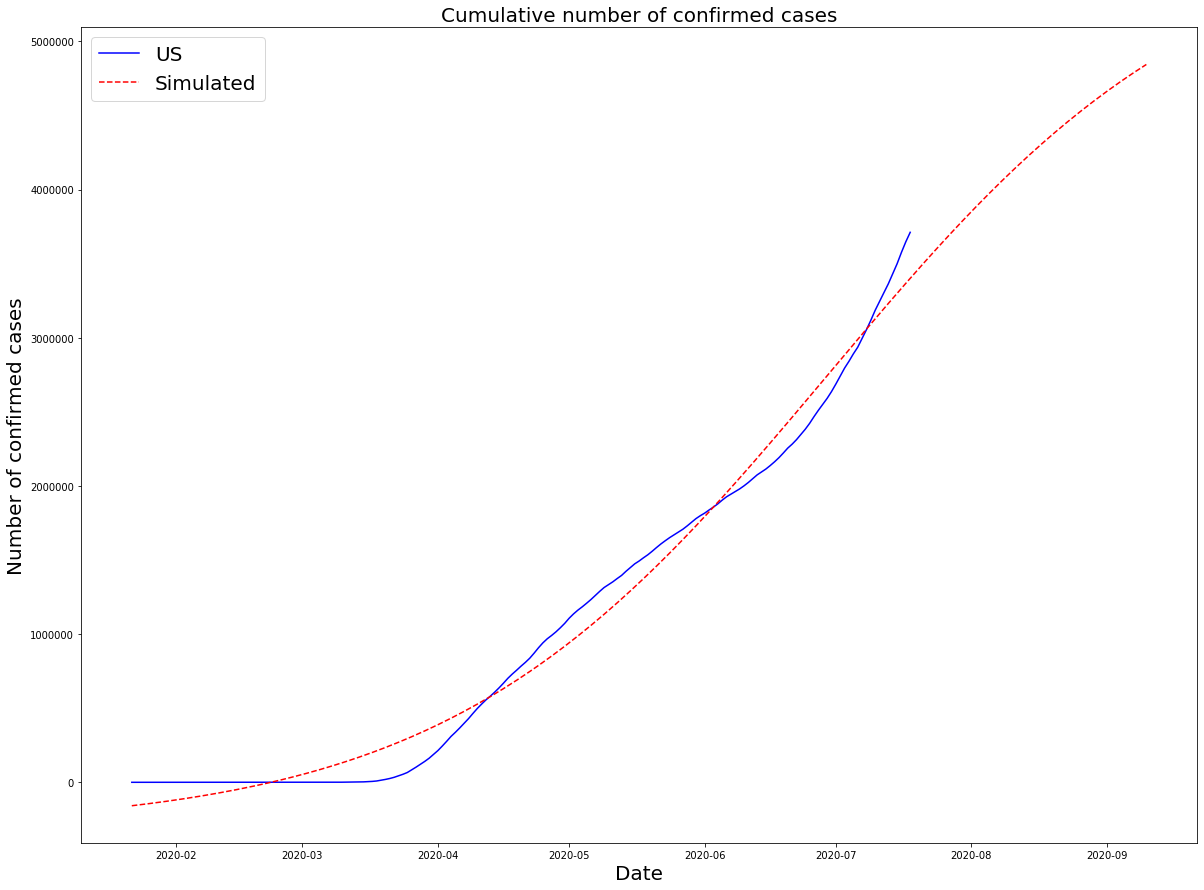

In [19]:
# US
example = 'US';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

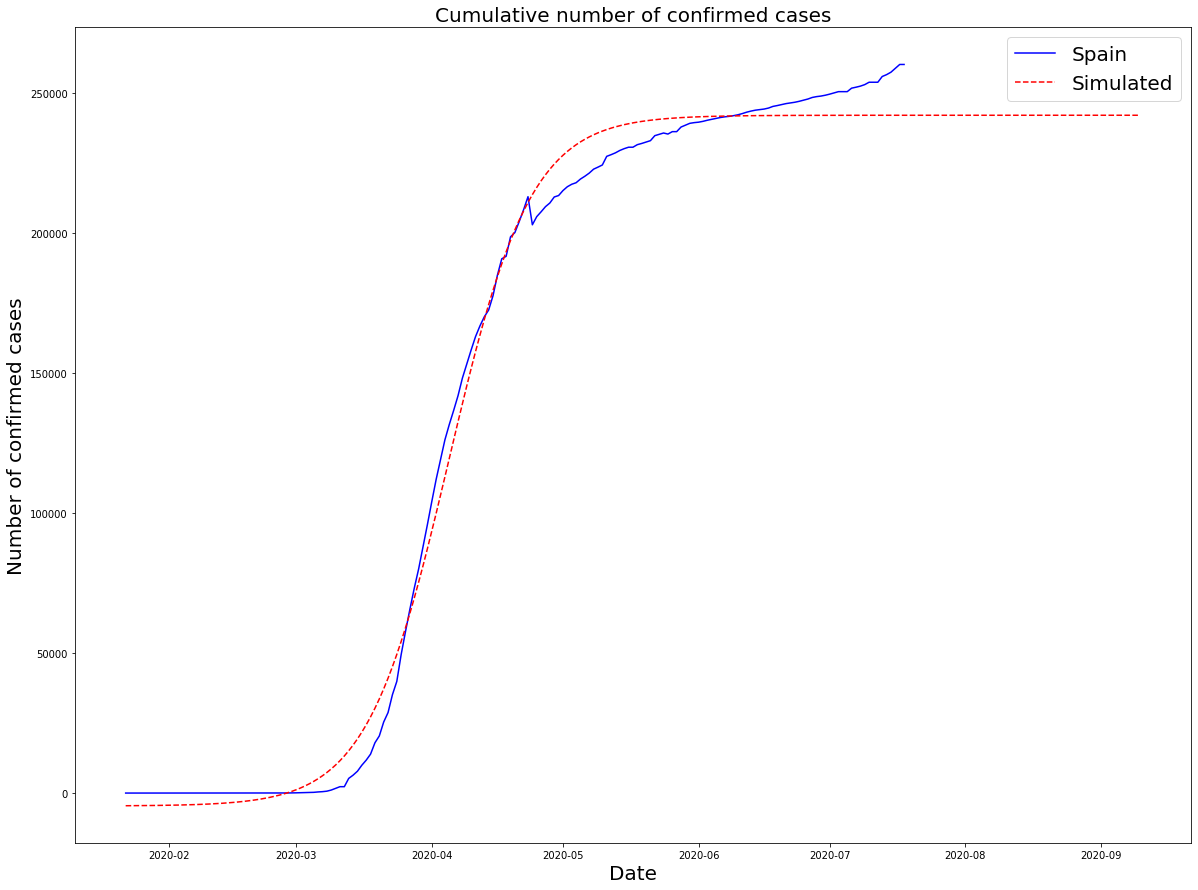

In [20]:
# Spain
example = 'Spain';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

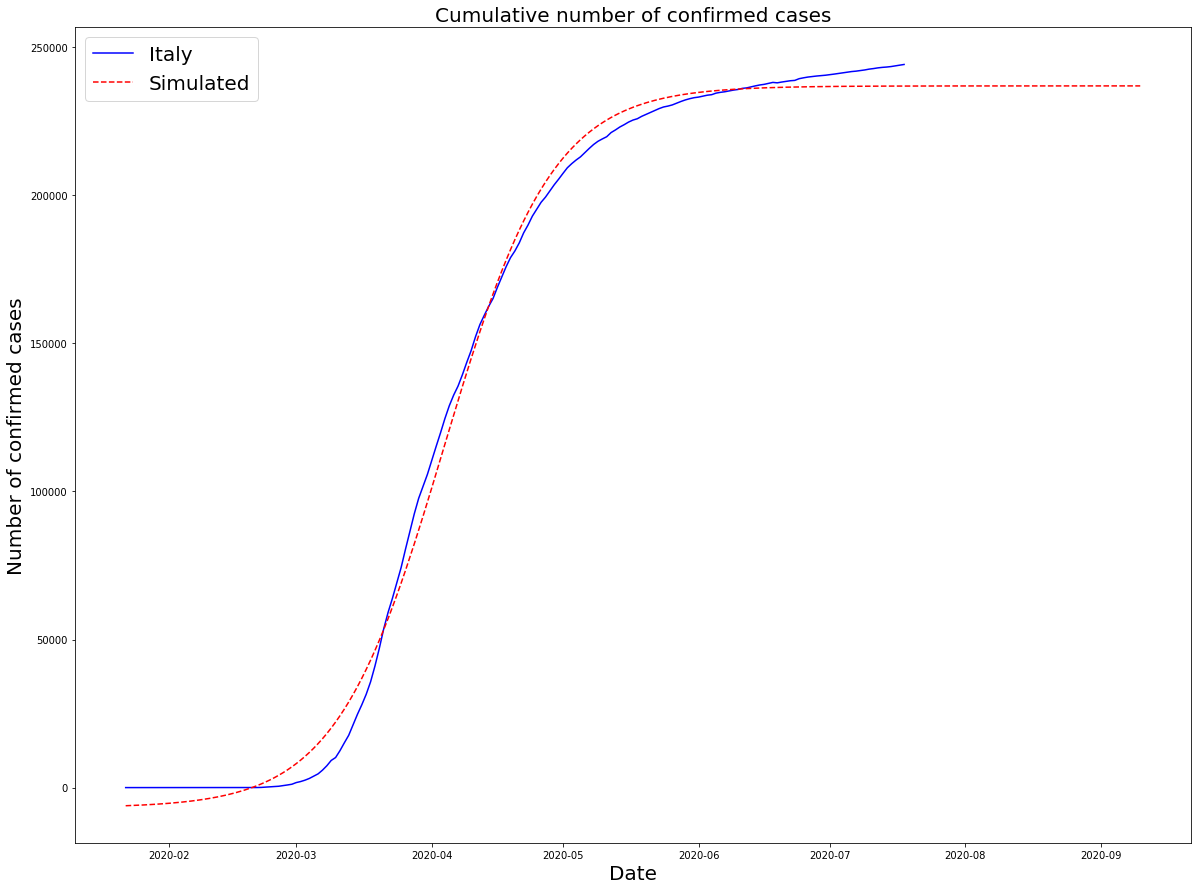

In [21]:
# Italy
example = 'Italy';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

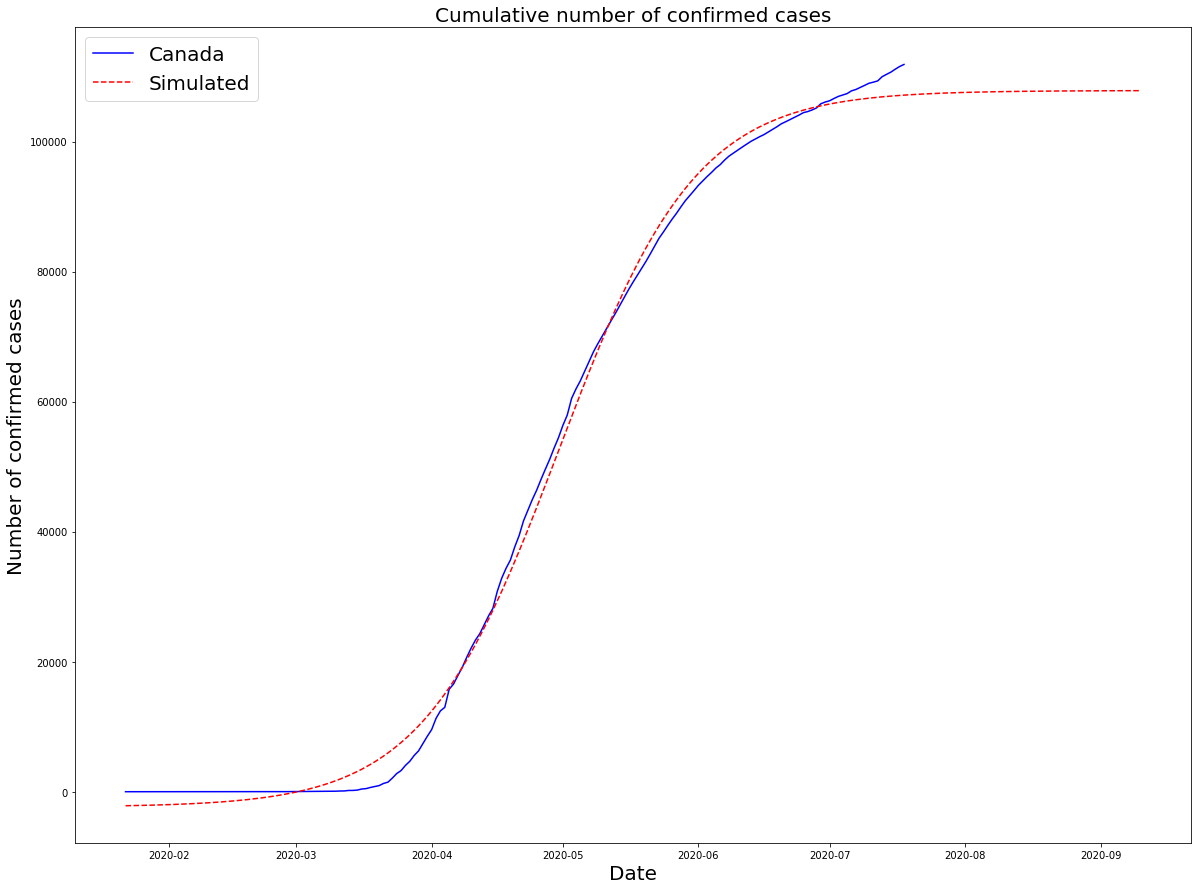

In [22]:
# Canada
example = 'Canada';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);